In [1]:
import cvxpy as cp # python 3.7 로 해야.... 하루종일 걸려서 발견...
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
import pickle 

from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

from IPython.display import Image


In [2]:
from labelling import XYGeneration

# Dataloading

## X loading 

In [3]:

def pd_setting(dataframe):
    dataframe.rename(columns = {'Unnamed: 0':'Date'}, inplace = True)
    dataframe['Date'] = dataframe.Date.apply(lambda x : datetime.datetime.strptime(x, '%Y-%m-%d') )
    dataframe = dataframe.set_index(['Date'])

    return dataframe

In [4]:
price_df = pd_setting(pd.read_csv("./data/features/price_df.csv"))
mu_df = pd_setting(pd.read_csv("./data/features/mu_df.csv"))
sigma_df = pd_setting(pd.read_csv("./data/features/sigma_df.csv"))

In [5]:
price_df.shape

(7931, 27)

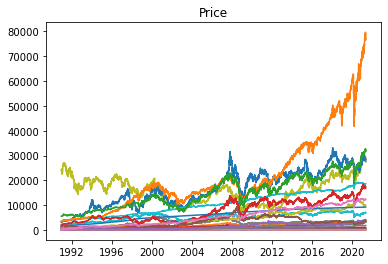

In [6]:
plt.title("Price")
plt.plot(price_df)
plt.show()

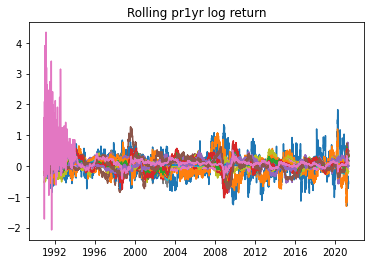

In [7]:
plt.title("Rolling pr1yr log return")
plt.plot(mu_df)
plt.show()

<AxesSubplot:xlabel='Date'>

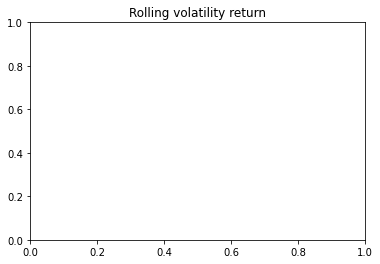

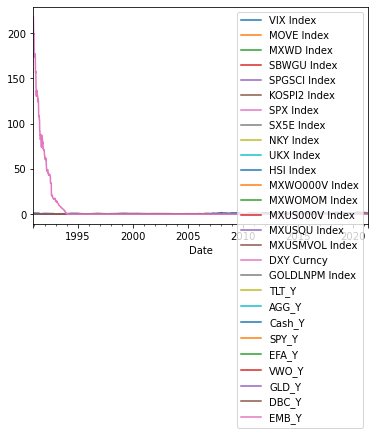

In [8]:
plt.title("Rolling volatility return")
sigma_df.plot()

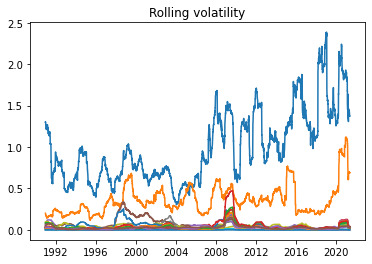

In [9]:
plt.title("Rolling volatility")
plt.plot(sigma_df.drop(['EMB_Y'], axis = 1))
plt.show()

## Y loading

In [10]:
feat_date = list(price_df.index)

In [11]:
dff = pd.read_csv("./data/df_XY.csv")
dff.rename(columns = {'Unnamed: 0':'Date'}, inplace = True)
dff['Date'] = dff.Date.apply(lambda x : datetime.datetime.strptime(x, '%Y-%m-%d') )
dff = dff.set_index(['Date'])

dfy = dff.loc[feat_date]
# extracting Y columns
Y_col = [x for x in dfy.columns if x[-2:]=='_Y']
dfy = dfy[Y_col]

In [12]:
dfy.shape

(7931, 9)

# XY Generation
- df_target : dfy
- df_intput : price_df, mu_df, sigma_df

## Scaling

In [13]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [14]:
dff_col_name = price_df.columns

In [15]:
dff.shape

(8184, 27)

In [16]:
price_df.shape

(7931, 27)

In [17]:
def scaler(df):
    df_col_name = df.columns
    feat_date = list(df.index)

    min_max_scaler = MinMaxScaler()
    min_max_scaler.fit(df)
    df_mm = min_max_scaler.transform(df)
    df_mm = pd.DataFrame(df_mm, columns = df_col_name, index = feat_date)
    
    return df_mm

In [18]:
#### scaling ####
price_df_mm = scaler(price_df)
mu_df_mm = scaler(mu_df)
sigma_df_mm = scaler(sigma_df)

# Dataset Generation & Labelling

In [19]:
# in_past_seq < tr_past_seq
in_past_seq = 120 # 6 months  
tr_past_seq = 253 # pr1yr
rf = 0.02

In [20]:
# Loading generator
generator = XYGeneration(dfy, tr_past_seq, rf)

# Y labelling 
Y, Y_date, Y_tot_date = generator.Y_generation()

### X concatenation 

In [21]:
# feature slicing & date slicing 
x_p, X_date = generator.X_generation(price_df_mm, in_past_seq)
x_m, _ = generator.X_generation(mu_df_mm, in_past_seq)
x_s, _ = generator.X_generation(sigma_df_mm, in_past_seq)

In [22]:
# features concatenating
X = []
for i in range(len(X_date)):
    x_p_arr = np.expand_dims(x_p[i], -1)
    x_m_arr = np.expand_dims(x_m[i], -1)
    x_s_arr = np.expand_dims(x_s[i], -1)
    
    X_arr = np.concatenate([x_p_arr, x_m_arr, x_s_arr], axis = -1)
    
    X.append(X_arr)
    

# DataLoader

- TESTING
- one-step ahead validation 

<img src="img/one step ahead validation.png" width="800" height="400">

In [23]:
from torch.utils.data import DataLoader
import torch

In [24]:
one_step_ahead = 0 

In [25]:
len(X)

353

In [26]:
len(X_date[0])

120

In [27]:
num_nodes = X[0].shape[1]
feat_dim = X[0].shape[-1]

# num_val = round(num_train*0.2)
num_samples = len(X)
num_train = round(len(X)*0.7) + one_step_ahead
# num_test = num_samples - num_train

num_test = 1

## train & test split
x_train, y_train = X[:num_train], Y[:num_train]
# x_val, y_val = X[num_train : num_train+num_val], Y[num_train : num_train+num_val]
x_test , y_test = X[num_train : num_train+1], Y[num_train : num_train+1]

In [28]:
num_samples - num_train

106

In [29]:

train_date_x, train_date_y = X_date[:num_train], Y_date[:num_train]
# 미래 한달 
test_date_x, test_date_y = X_date[num_train:num_train+1], Y_date[num_train:num_train+1]
test_date_tot_y = Y_tot_date[num_train:num_train+1] # labelling 계산할 때 씌인 기간 

In [30]:
len(Y_date)

353

In [31]:
len(test_date_tot_y[0])

275

In [32]:
train_iter = ([(torch.from_numpy(x).float(),torch.from_numpy(y).float()) for x,y in zip(x_train, y_train)])
# val_iter = ([(torch.from_numpy(x).float(),torch.from_numpy(y).float()) for x,y in zip(x_val, y_val)])
test_iter = ([(torch.from_numpy(x).float(),torch.from_numpy(y).float()) for x,y in zip(x_test, y_test)])


In [33]:
### dataloader
train_dataloader = DataLoader(train_iter, batch_size=12, shuffle=True, drop_last = True)
# valid_dataloader = DataLoader(val_iter, batch_size=12, shuffle=True, drop_last = True)
test_dataloader = DataLoader(test_iter, batch_size=1, shuffle=True, drop_last = True)

# Model 

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import sys


class nconv(nn.Module):
    def __init__(self):
        super(nconv,self).__init__()

    def forward(self,x, A):
        x = torch.einsum('ncvl,vw->ncwl',(x,A))
        return x.contiguous()

class linear(nn.Module):
    def __init__(self,c_in,c_out):
        super(linear,self).__init__()
        self.mlp = torch.nn.Conv2d(c_in, c_out, kernel_size=(1, 1), padding=(0,0), stride=(1,1), bias=True) # 

    def forward(self,x):
        return self.mlp(x)

class gcn(nn.Module):
    def __init__(self,c_in,c_out,dropout,support_len=3,order=2):
        super(gcn,self).__init__()
        self.nconv = nconv()
        c_in = (order*support_len+1)*c_in
        self.mlp = linear(c_in,c_out)
        self.dropout = dropout
        self.order = order

    def forward(self,x,support):
        out = [x]
        for a in support:
            x1 = self.nconv(x,a)
            out.append(x1)
            for k in range(2, self.order + 1):
#                 print ("K")
#                 print (k)
                
                
#                 print (x1.shape)
#                 print (a.shape)
                
                x2 = self.nconv(x1,a)
                out.append(x2)
                x1 = x2
        
        h = torch.cat(out,dim=1)
        h = self.mlp(h)
        h = F.dropout(h, self.dropout, training=self.training)
        return h
    
###############################################################################################################################################
###############################################################################################################################################
class gwnet(nn.Module):
    def __init__(self, device, num_nodes, dropout=0.3, supports=None, gcn_bool=True, addaptadj=True, aptinit=None, 
                 in_dim=3, out_dim=1, out_dim2 = 9, residual_channels=32,dilation_channels=32,skip_channels=256,
                 end_channels=512,kernel_size=2,blocks=4,layers=2):
        super(gwnet, self).__init__()
        self.dropout = dropout
        self.blocks = blocks
        self.layers = layers
        self.gcn_bool = gcn_bool
        self.addaptadj = addaptadj

        self.filter_convs = nn.ModuleList()
        self.gate_convs = nn.ModuleList()
        self.residual_convs = nn.ModuleList()
        self.skip_convs = nn.ModuleList()
        self.bn = nn.ModuleList()
        self.gconv = nn.ModuleList()

        self.start_conv = nn.Conv2d(in_channels=in_dim,
                                    out_channels=residual_channels,
                                    kernel_size=(1,1))
        self.supports = supports

        receptive_field = 1

        self.supports_len = 0
        if supports is not None:
            self.supports_len += len(supports)

        if gcn_bool and addaptadj:
            if aptinit is None:
                if supports is None:
                    self.supports = []
                self.nodevec1 = nn.Parameter(torch.randn(num_nodes, 10).to(device), requires_grad=True).to(device)
                self.nodevec2 = nn.Parameter(torch.randn(10, num_nodes).to(device), requires_grad=True).to(device)
                self.supports_len +=1
            else:
                if supports is None:
                    self.supports = []
                m, p, n = torch.svd(aptinit)
                initemb1 = torch.mm(m[:, :10], torch.diag(p[:10] ** 0.5))
                initemb2 = torch.mm(torch.diag(p[:10] ** 0.5), n[:, :10].t())
                self.nodevec1 = nn.Parameter(initemb1, requires_grad=True).to(device)
                self.nodevec2 = nn.Parameter(initemb2, requires_grad=True).to(device)
                self.supports_len += 1

        for b in range(blocks):
            additional_scope = kernel_size - 1
            new_dilation = 1
            for i in range(layers):
                # dilated convolutions
                self.filter_convs.append(nn.Conv2d(in_channels=residual_channels,
                                                   out_channels=dilation_channels,
                                                   kernel_size=(1,kernel_size),dilation=new_dilation))

                self.gate_convs.append(nn.Conv1d(in_channels=residual_channels,
                                                 out_channels=dilation_channels,
                                                 kernel_size=(1, kernel_size), dilation=new_dilation))

                # 1x1 convolution for residual connection
                self.residual_convs.append(nn.Conv1d(in_channels=dilation_channels,
                                                     out_channels=residual_channels,
                                                     kernel_size=(1, 1)))

                # 1x1 convolution for skip connection
                self.skip_convs.append(nn.Conv1d(in_channels=dilation_channels,
                                                 out_channels=skip_channels,
                                                 kernel_size=(1, 1)))
                self.bn.append(nn.BatchNorm2d(residual_channels))
                new_dilation *=2
                
                
#                 print ('dilation: ', new_dilation)
                
                
                receptive_field += additional_scope
                additional_scope *= 2
                if self.gcn_bool:
                    self.gconv.append(gcn(dilation_channels,residual_channels,dropout,support_len=self.supports_len))



        self.end_conv_1 = nn.Conv2d(in_channels=skip_channels,
                                  out_channels=end_channels,
                                  kernel_size=(1,1),
                                  bias=True)

        self.end_conv_2 = nn.Conv2d(in_channels=end_channels,
                                    out_channels=out_dim,
                                    kernel_size=(1,1),
                                    bias=True)
        
        self.end_conv_3 = nn.Conv2d(in_channels = num_nodes,
                                   out_channels = out_dim2, 
                                   kernel_size = (1,1), 
                                   bias = True)
        
        self.soft_max = nn.Softmax(dim = 1) # every row will sum to 1 
        
        self.receptive_field = receptive_field

    def forward(self, input):
        in_len = input.size(3)
        if in_len<self.receptive_field:
            x = nn.functional.pad(input,(self.receptive_field-in_len,0,0,0))
        else:
            x = input
        x = self.start_conv(x)
        skip = 0

        # calculate the current adaptive adj matrix once per iteration
        new_supports = None
        if self.gcn_bool and self.addaptadj and self.supports is not None:
            adp = F.softmax(F.relu(torch.mm(self.nodevec1, self.nodevec2)), dim=1)
            new_supports = self.supports + [adp]

        # WaveNet layers
        for i in range(self.blocks * self.layers):
#             print ('layers: ', self.blocks * self.layers)

            #            |----------------------------------------|     *residual*
            #            |                                        |
            #            |    |-- conv -- tanh --|                |
            # -> dilate -|----|                  * ----|-- 1x1 -- + -->	*input*
            #                 |-- conv -- sigm --|     |
            #                                         1x1
            #                                          |
            # ---------------------------------------> + ------------->	*skip*

            #(dilation, init_dilation) = self.dilations[i]

            #residual = dilation_func(x, dilation, init_dilation, i)
            residual = x
            # dilated convolution
            filter = self.filter_convs[i](residual)
            filter = torch.tanh(filter)
            gate = self.gate_convs[i](residual)
            gate = torch.sigmoid(gate)
            x = filter * gate

            # parametrized skip connection

            s = x
            s = self.skip_convs[i](s)
            try:
                skip = skip[:, :, :,  -s.size(3):]
            except:
                skip = 0
            skip = s + skip

            if self.gcn_bool and self.supports is not None:
                if self.addaptadj:
                    x = self.gconv[i](x, new_supports)
                else:
                    x = self.gconv[i](x,self.supports)
            else:
                x = self.residual_convs[i](x)

            x = x + residual[:, :, :, -x.size(3):]


            x = self.bn[i](x)

        x = F.relu(skip)
        x = F.relu(self.end_conv_1(x))
        x = self.end_conv_2(x) # [batch, dim, num_nodes, seq]
        # [12,1,27,1]
                
        x = x.transpose(2,1) # [12,27,1,1] [batch, num node, 1, 1]
        x = self.end_conv_3(x).transpose(3,1) 
        # [12,27,1,1] --> [12,9,1,1] --> [12,1,1,9] 
        
        return x, new_supports

In [35]:
device = torch.device("cuda:1")
num_nodes = 27
dropout = 0.3
learning_rate = 0.001
wdecay = 0.0001

gcn_bool = True
addaptadj=True
aptinit=None
in_dim = 3
out_dim = 1
out_dim2 = 9
nhid = 32

kernel_size = 20

residual_channels=nhid 
dilation_channels=nhid
skip_channels=nhid * 8
end_channels=nhid * 16

num_block = 4
num_layer = 2

In [36]:
# model 
model = gwnet(device,num_nodes,dropout,supports=None,gcn_bool=gcn_bool,addaptadj=addaptadj,aptinit=aptinit,in_dim=in_dim,out_dim=out_dim, out_dim2=out_dim2,residual_channels=nhid,dilation_channels=nhid,skip_channels=nhid * 8,end_channels=nhid*16,kernel_size=20,blocks=num_block,layers=num_layer)
model.to(device) # model loading

criterion = torch.nn.L1Loss() # MAE 
# criterion = torch.nn.MSELoss() # MSE 

# criterion = torch.nn.L1Loss() # MAE 
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = wdecay)

# Training

In [37]:
num_epochs = 50

loss_train = []
loss_valid = []

for epoch in range(1, num_epochs+1):
    model.train()

    epoch_train_loss = [] # loss average for one epoch
    epoch_valid_loss = []
##### training 
    for data in train_dataloader:
        optimizer.zero_grad()

        train_X, train_Y = data
        train_X = train_X.transpose(3,1)
        train_X = nn.functional.pad(train_X,(kernel_size-1,0,0,0))

        train_X = torch.Tensor(train_X).to(device)
        train_Y = torch.Tensor(train_Y).to(device)
#         print ('X : ', train_X.size())
#         print ('Y : ', train_Y.size())
        train_out, adp = model(train_X)
#         print ('out : ', train_out.size())
        train_out = train_out.squeeze()
#         print('out: ',train_out.size())

        loss = criterion(train_out,train_Y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss.append(loss.item())

    loss_train.append(np.mean(epoch_train_loss))
    
# ##### validation 
#     for data in valid_dataloader:
#         valid_X, valid_Y = data
#         valid_X = valid_X.transpose(3,1)
#         valid_X = nn.functional.pad(valid_X, (kernel_size-1,0,0,0))
        
#         valid_X = torch.Tensor(valid_X).to(device)
#         valid_Y = torch.Tensor(valid_Y).to(device)
        
#         valid_out, _ = model(valid_X)
#         valid_out = valid_out.squeeze()
        
#         loss = criterion(valid_out, valid_Y)
        
#         epoch_valid_loss.append(loss.item())
#     loss_valid.append(np.mean(epoch_valid_loss))
    
#     if epoch%50 == 0:
#         print ("Epoch {}| tarin loss : {}, valid loss : {}".format(epoch,np.mean(epoch_train_loss), np.mean(epoch_valid_loss)))
    
    if epoch%10 == 0:
        print ("Epoch {}| tarin loss : {}".format(epoch,np.mean(epoch_train_loss)))

Epoch 10| tarin loss : 0.0066701939213089645
Epoch 20| tarin loss : 0.0064073576591908935
Epoch 30| tarin loss : 0.0027859040535986425
Epoch 40| tarin loss : 0.0038025653338991106
Epoch 50| tarin loss : 0.0019390578730963171


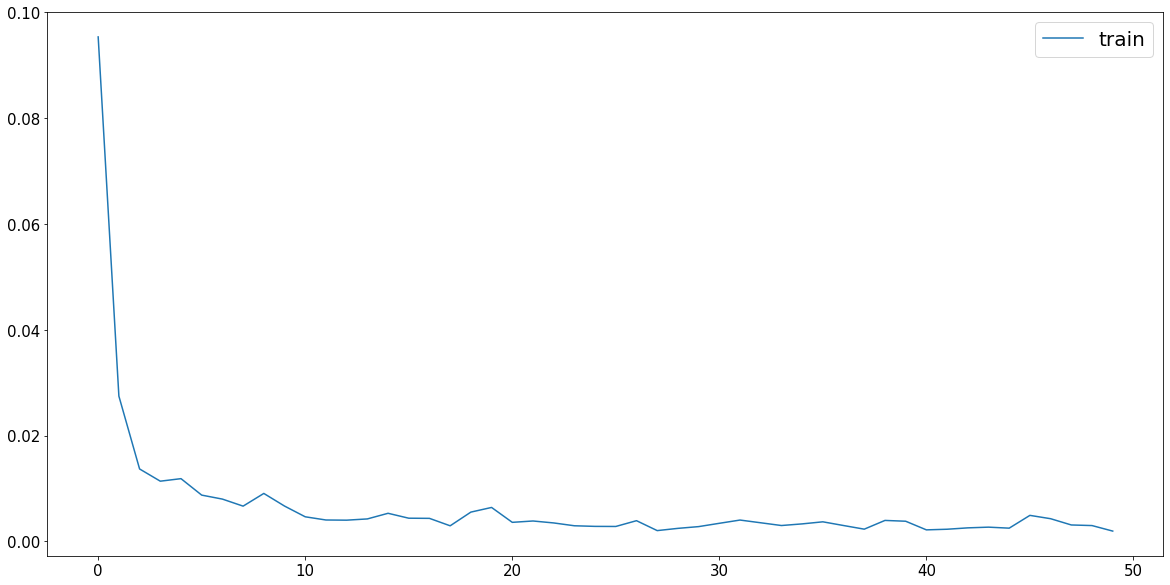

In [38]:
plt.figure(figsize = (20,10))
plt.plot(loss_train, label = 'train')
# plt.plot(loss_valid, label = 'valid')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = (20))

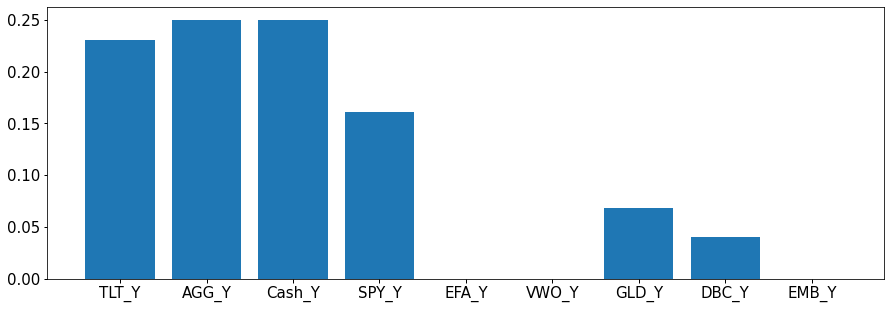

In [39]:
plt.figure(figsize = (15,5))
plt.bar(Y_col,train_Y[10].detach().cpu())
plt.tick_params(width=1)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

In [40]:
train_out[10].detach().cpu()

tensor([2.2856e-01, 2.5273e-01, 2.5194e-01, 1.6341e-01, 5.3611e-05, 1.8063e-03,
        6.8933e-02, 4.5136e-02, 1.3985e-03])

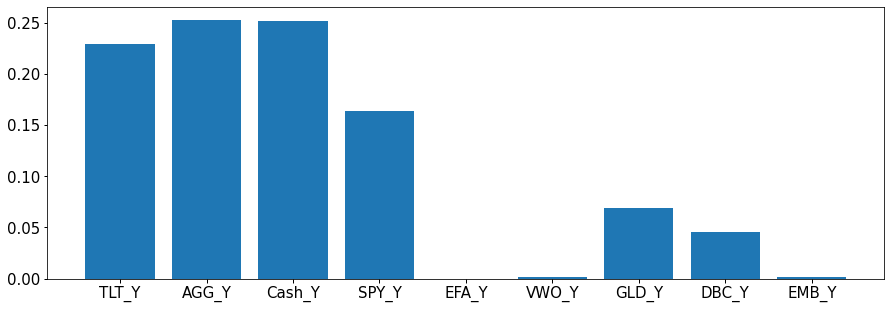

In [41]:
plt.figure(figsize = (15,5))
plt.bar(Y_col,train_out[10].detach().cpu())
plt.tick_params(width=1)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

# Testing 
- one-step ahead validation 

<img src="img/one step ahead validation.png" width="800" height="400">

In [42]:
model.eval()

test_loss = []
##### TESTING ##############
for data in test_dataloader:
    test_X, test_Y = data
    test_X = test_X.transpose(3,1)
    test_X = nn.functional.pad(test_X, (kernel_size-1,0,0,0))

    test_X = torch.Tensor(test_X).to(device)
    test_Y = torch.Tensor(test_Y).to(device)

    test_out, adp = model(test_X)
    adp = adp[0].detach().cpu() # sel
    test_out = test_out.squeeze() # [9]
    test_out = test_out.unsqueeze(0) # [1,9]
    
    loss = criterion(test_out, test_Y)

    test_loss.append(loss.item())
    
    
# loss_valid.append(np.mean(epoch_valid_loss))


In [62]:
len(dff_col_name)

27

Text(0.5, 1.0, 'Self-adaptive adjacency matrix')

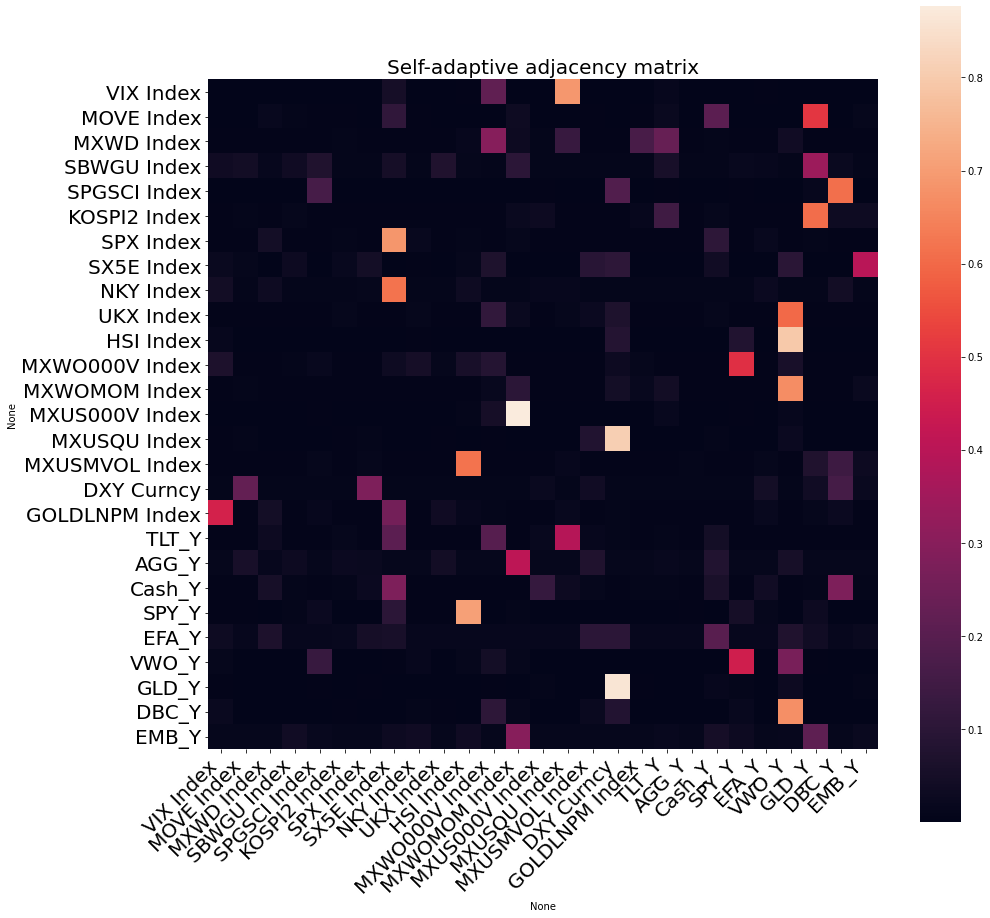

In [72]:
plt.figure(figsize = (15,15))
h= sns.heatmap(pd.DataFrame(adp.numpy(), columns = [dff_col_name], index = [dff_col_name]), square = True)
h.set_xticklabels(h.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xticks(fontsize = (20))
plt.yticks(fontsize = (20))
plt.title("Self-adaptive adjacency matrix", fontsize = 20)

<AxesSubplot:>

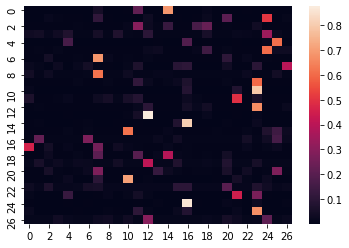

In [60]:
sns.heatmap(adp)

In [43]:
test_loss

[0.00335104507394135]

# Saving values
- three lists 
     1. [pred weight, 수익률, volatility]
     2. [true weight, 수익률, volatility]
     3. [loss, future 1 month date, columns] 
  
- 수익률, volatility
    - 정해진 weight 로 미래 한달간 가격에 대한 weighted log-return 


In [44]:
def return_volatility(df_bench):
    '''
    return & volatility
    '''  
    logret = np.log(df_bench/df_bench.shift(1)).dropna()
    T = logret.shape[0]

    sigma = logret.cov() * T # annualize sigma (check again)
    mu = logret.mean()*T

    return mu, sigma

In [45]:
dfy

,TLT_Y,AGG_Y,Cash_Y,SPY_Y,EFA_Y,VWO_Y,GLD_Y,DBC_Y,EMB_Y
Date,,,,,,,,,
1990-12-20,1060.220000,3509.748172,1559.667686,3400.033584,5499.752506,1861.60000,752.832031,1394.786000,3840.07261
1990-12-21,1053.940000,3500.731113,1560.258223,3416.797574,5499.752506,1852.40000,749.511719,1390.308000,3778.07261
1990-12-24,1045.880000,3490.333063,1561.998865,3400.311440,5499.752506,1835.90000,749.511719,1392.098000,4011.07261
1990-12-25,1045.880000,3490.333063,1561.998865,3400.311440,5499.752506,1830.90000,749.511719,1392.098000,3798.07261
1990-12-26,1053.110000,3500.406174,1563.232202,3410.314263,5499.752506,1828.30000,749.511719,1414.333000,3752.07261
...,...,...,...,...,...,...,...,...,...
2021-05-07,10044.636410,18639.685120,9195.975652,79683.136810,32776.749570,17588.93250,3449.782195,3901.717983,1000.00000
2021-05-10,9942.914377,18610.402170,9196.330422,78894.114390,32601.459520,17260.16018,3460.235035,3874.636158,1000.00000
2021-05-11,9886.637481,18569.738440,9196.472964,78189.984420,32173.467560,17214.12733,3460.837116,3916.300121,1000.00000


In [46]:
### 라벨링 할 때 쓰였던 동일한 기간에 대한 수익률과 volatility 구한다. 
# price slicing
test_price = dfy.loc[test_date_tot_y[0][0]:test_date_tot_y[0][-1]]
# test_price = dfy.loc[test_date_y[0][0]:test_date_y[0][-1]]
# bench mu, volatility calculation 
test_mu, test_sigma = return_volatility(test_price)

<AxesSubplot:xlabel='Date'>

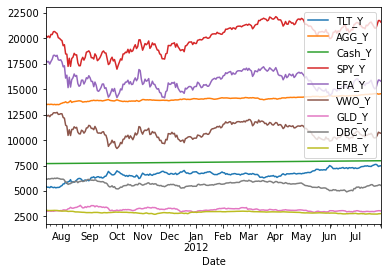

In [47]:
test_price.plot()

In [48]:
test_sigma

,TLT_Y,AGG_Y,Cash_Y,SPY_Y,EFA_Y,VWO_Y,GLD_Y,DBC_Y,EMB_Y
TLT_Y,0.045130,0.006495,0.000029,-0.036023,-0.045638,-0.046611,0.004634,-0.019541,-0.000478
AGG_Y,0.006495,0.001318,0.000002,-0.004236,-0.005444,-0.005388,0.001413,-0.002102,-0.000190
Cash_Y,0.000029,0.000002,0.000002,-0.000003,-0.000022,-0.000032,0.000019,-0.000012,-0.000007
SPY_Y,-0.036023,-0.004236,-0.000003,0.055114,0.067808,0.070223,0.000892,0.029703,-0.000344
EFA_Y,-0.045638,-0.005444,-0.000022,0.067808,0.094179,0.092798,0.008210,0.039008,0.000057
VWO_Y,-0.046611,-0.005388,-0.000032,0.070223,0.092798,0.105613,0.011661,0.044137,-0.000596
GLD_Y,0.004634,0.001413,0.000019,0.000892,0.008210,0.011661,0.049492,0.016154,-0.001974
DBC_Y,-0.019541,-0.002102,-0.000012,0.029703,0.039008,0.044137,0.016154,0.035457,-0.000148
EMB_Y,-0.000478,-0.000190,-0.000007,-0.000344,0.000057,-0.000596,-0.001974,-0.000148,0.006753


In [49]:
# weight setting
pred_w = test_out.detach().cpu()[0].numpy()
true_w = test_Y.detach().cpu()[0].numpy()

### mu, sigma rebalancing


In [50]:
# mu
pred_mu = round(pred_w.dot(test_mu.values), 5)
true_mu = round(true_w.dot(test_mu.values), 5)

# sigma
pred_sigma = round(np.sqrt(pred_w.dot(test_sigma.values).dot(pred_w.T)), 5)
true_sigma = round(np.sqrt(true_w.dot(test_sigma.values).dot(true_w.T)), 5)

In [51]:
true_sigma

0.04706

## Saving as one dataframe

In [52]:
fold_dict = {}
fold_dict['Date']= ([[test_date_y[0][0], test_date_y[0][-1]]])
# fold_dict['X_date'] = ([[test_date_x_m[0], test_date_x_m[-1]]])
fold_dict['pred_w']= [list(pred_w)]
fold_dict['pred_mu']= pred_mu
fold_dict['pred_sigma']=pred_sigma
fold_dict['true_w']=[list(true_w)]
fold_dict['true_mu']=true_mu
fold_dict['true_sigma']=true_sigma
fold_dict['test_loss(%)']=round(test_loss[0], 4)*100


In [53]:
a = pd.DataFrame.from_dict(fold_dict)

In [54]:
a

,Date,pred_w,pred_mu,pred_sigma,true_w,true_mu,true_sigma,test_loss(%)
0,"[2012-07-02 00:00:00, 2012-07-31 00:00:00]","[0.22591467, 0.24165617, 0.24451597, 0.1621542...",0.10422,0.04692,"[0.23019, 0.25, 0.25, 0.16116, 0.0, 0.0, 0.068...",0.10713,0.04706,0.34


In [55]:
with open("./RESULT/result_{}.pickle".format(1), 'wb') as f:
    pickle.dump(a, f)

In [56]:
with open("./RESULT/result_{}.pickle".format(1), 'rb') as f:
    res = pickle.load(f)

In [57]:
pd.DataFrame(pd.read_pickle("./RESULT/result_{}.pickle".format(1)))

,Date,pred_w,pred_mu,pred_sigma,true_w,true_mu,true_sigma,test_loss(%)
0,"[2012-07-02 00:00:00, 2012-07-31 00:00:00]","[0.22591467, 0.24165617, 0.24451597, 0.1621542...",0.10422,0.04692,"[0.23019, 0.25, 0.25, 0.16116, 0.0, 0.0, 0.068...",0.10713,0.04706,0.34


In [58]:
df = pd.DataFrame(pd.read_pickle(os.path.join(event_speed_path, f_name)))
    

NameError: name 'os' is not defined

In [ ]:
test_price.plot()

In [ ]:
list(dff.columns).index('Cash_Y')

In [ ]:
list(dff.columns)

In [ ]:
adp[20]

In [ ]:
test_out.detach().cpu()[0]

In [ ]:
test_Y.detach().cpu()[0]

In [ ]:
test_out.detach().cpu()[0]

In [ ]:

plt.figure(figsize = (15,5))
plt.bar(Y_col,test_out.detach().cpu()[0])
plt.tick_params(width=1)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.title("{}~{}".format(test_date_y[0][0],test_date_y[0][1]))
plt.show()

In [ ]:
test_Y.detach().cpu()